In [128]:
import torch
from torch.utils.data import DataLoader
from torch.functional import F
from torchvision.transforms import transforms
from torchvision.datasets import ImageFolder

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc

In [129]:
data_dir = '../data/'
test_dir = data_dir + 'images/test/'

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_set = ImageFolder(test_dir, transform=transform, target_transform=None)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

In [130]:
model = torch.load('../models/ResNet50_pretrained-epoch94-batch_size32-lr0.01-loss0.0440.pt')
model.eval();
device = next(model.parameters()).device.type

In [131]:
pred = []
true = []
probs = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        output = model(images)

        probs += F.softmax(output, dim=1).cpu().numpy().tolist()
        _, predicted = torch.max(output, 1)
        pred += predicted.cpu().numpy().tolist()
        true += labels.numpy().tolist()

probs = np.array(probs)
pred = np.array(pred)
true = np.array(true)

accuracy = (true == pred).sum() / len(true)
print(f'Test Accuracy: {accuracy:.2%}')

Test Accuracy: 99.48%


Class 0 AUC-ROC: 0.9999


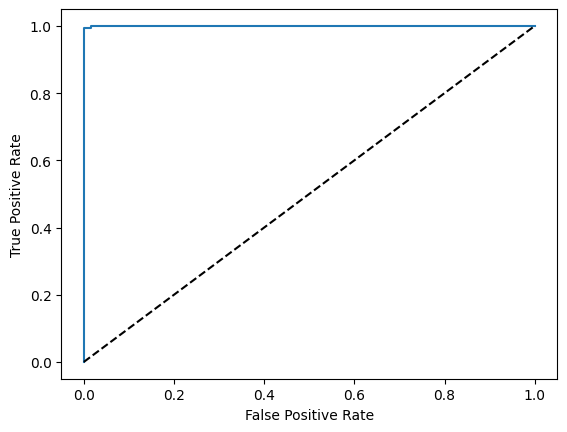

Class 1 AUC-ROC: 1.0000


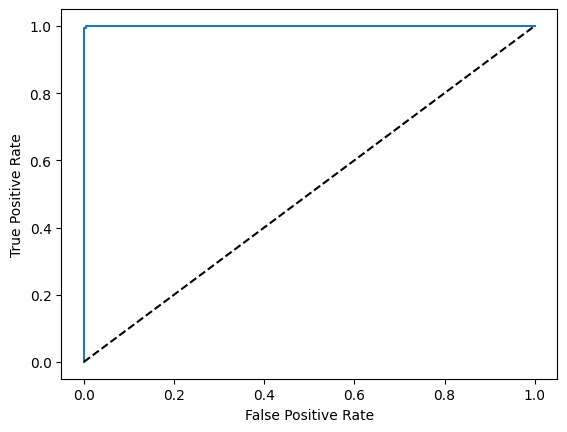

Class 2 AUC-ROC: 1.0000


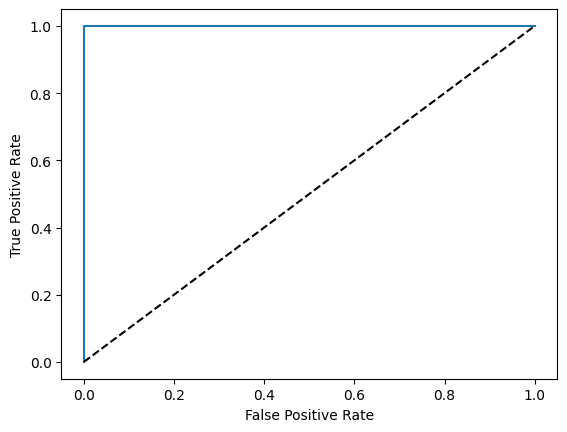

Average AUC-ROC: 0.9999


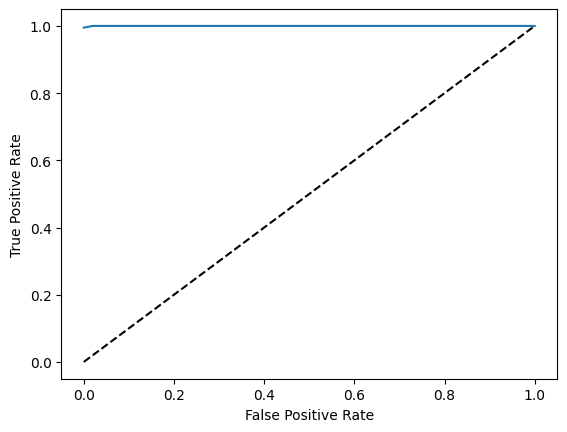

In [132]:
### OvR ROC ###

for i in range(probs.shape[1]):
    fpr, tpr, _ = roc_curve(true == i, probs[:, i])

    auc_roc = auc(fpr, tpr)
    print(f'Class {i} AUC-ROC: {auc_roc:.4f}')

    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()

### OvR average ROC ###

fpr = []
tpr = []
for i in range(probs.shape[1]):
    ovr_fpr, ovr_tpr, _ = roc_curve(true == i, probs[:, i])
    fpr.append(ovr_fpr)
    tpr.append(ovr_tpr)

fpr_grid = np.linspace(0.0, 1.0, 100)

# Interpolate ROC curves
mean_tpr = np.zeros_like(fpr_grid)
for i in range(probs.shape[1]):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])

mean_tpr /= probs.shape[1]

auc_roc = auc(fpr_grid, mean_tpr)
print(f'Average AUC-ROC: {auc_roc:.4f}')

plt.plot(fpr_grid, mean_tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

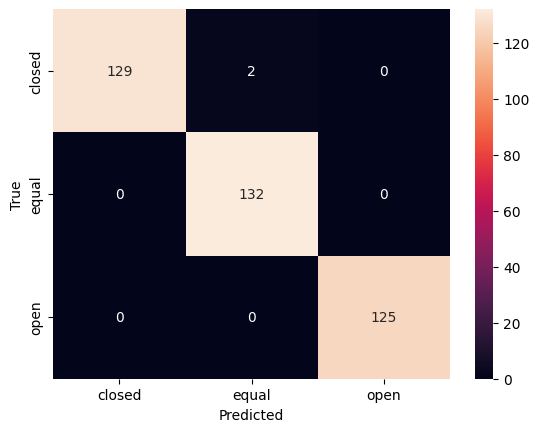

In [133]:
class_to_idx = test_set.class_to_idx
labels = [k for k, v in sorted(class_to_idx.items(), key=lambda item: item[1])]

cm = confusion_matrix(true, pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()